## 빅데이터 실습

### 다나와 무선청소기 상품 분석

#### 데이터 수집

##### 셀레니움 사용

In [1]:
# 필요 라이브러리 등록
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
from urllib import parse  # url encode
from tqdm import tqdm

import time

In [2]:
## 웹드라이버로 크롬오픈
driver = webdriver.Chrome()

url = r'https://search.danawa.com/dsearch.php?query=무선청소기&page=1&limit=120&sort=saveDESC&list=list'

driver.get(url)

In [3]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [4]:
prodItems = soup.select('ul.product_list > li.prod_item')
len(prodItems)

122

In [5]:
prodItems[0].select('p.prod_name > a')[0].text.strip()

'LG전자 오브제컬렉션 코드제로 A9S AX9884'

In [6]:
prodItems[0].select('div.spec_list')[0].text.strip().replace('\t', '').replace(' / ', ' ,')

'핸디스틱청소기 ,무선 ,흡입+물걸레(동시) ,흡입력: 250W ,소비전력: 620W ,2023년형 ,[구성] 거치대: 올인원타워 ,먼지비움 ,충전 ,UVC LED ,액서서리수납 ,스탠드거치 ,먼지비움시간: 30초 ,브러쉬: 와이드바닥 ,물걸레: 스팀, 고온, 일반 ,솔형 ,틈새 ,먼지봉투: 2.5L ,[배터리] 사용시간: 30분(최대) ,충전시간: 4시간 ,분리형(2개) ,리튬이온 ,25.2V ,[청소] 싸이클론흡입 ,LED라이트 ,자동물공급 ,스마트인버터모터 ,[부가] 스마트폰제어 ,대화형알림창 ,워셔블헤파필터 ,5단계여과 ,색상: 카밍베이지 ,무게: 2.47kg ,크기(가로x세로x깊이): 300x1120x245mm'

In [7]:
# 만약 수가 아닌 문자열일땐 False
# isdecimal() 메서드는 문자열이 모두 10진수로 표현될 수 있는지 여부를 확인
prodItems[0].select('input')[1].get('value').isdecimal()

True

#### 다나와 무선청소기 웹크롤링 (~day07)
- 가격외에는 안들어오도록 변환

In [8]:
## 검색어, 페이지를 변경하면서 URL 생성함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
            'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
            'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
            'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [9]:
## 상품정보 추출하는 함수
def getProdItems(prodItems):
    prodData = []

    for prodItem in prodItems:
        try:
            prodName = prodItem.select('p.prod_name > a')[0].text.strip()  # 상품명 가져오기
            specList = prodItem.select('div.spec_list')[0].text.strip().replace('\t', '') # 상품 스펙목록 가져오기
            
            if prodItem.select('input')[1].get('value').isdecimal():
                price = prodItem.select('input')[1].get('value') # 최저가 가져오기        
            else :
                price = 0 # 문자열 X

            prodData.append([prodName, specList, price])
        except:
            pass
    
    return prodData

In [10]:
# 여러페이지 검색 후 크롤링하는 작업
driver = webdriver.Chrome()
# 암묵적으로 웹 자원 로드를 위해 3초정도 대기
driver.implicitly_wait(3.0)

keyword = '무선청소기'
# startPage 선언
startPage = 1
totalPage = 20
prodDataTotal = []

# range 범위 변경
for page in tqdm(range(startPage, totalPage+1)):
    url = getSearchPageUrl(keyword, page)
    driver.get(url)
    time.sleep(5)
    
    # 현재 페이지 HTML 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 상품정보 추출
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems)
    
    # 추출된 정보를 prodDataTotal 추가
    prodDataTotal += prodItemList

100%|██████████| 20/20 [02:55<00:00,  8.77s/it]


In [11]:
len(prodDataTotal)

2400

In [12]:
dfProdDataTotal = pd.DataFrame(prodDataTotal)

In [13]:
dfProdDataTotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2400 non-null   object
 1   1       2400 non-null   object
 2   2       2400 non-null   object
dtypes: object(3)
memory usage: 56.4+ KB


In [44]:
dfProdDataTotal.columns = ['제조회사', '제품스펙', '최저가']

dfProdDataTotal

,제조회사,제품스펙,최저가
0,LG전자 오브제컬렉션 코드제로 A9S AX9884,핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 250W / 소비전력: ...,875210
1,삼성전자 비스포크 제트 VS20B956AX,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 220W / 2022년형 / [구성]...,446390
2,샤오미 미홀 M22,핸디스틱청소기 / 무선 / 흡입형 / 소비전력: 320W / 2023년형 / [구성...,151050
3,LG전자 오브제컬렉션 코드제로 A9S AX9604,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 250W / 소비전력: 620W / ...,715560
4,LG전자 오브제컬렉션 코드제로 A9S AX9988,핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 280W / 소비전력: ...,1229240
...,...,...,...
2395,다이슨 V15 오리진 플러피,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 200AW / 2023년형 / [구성...,636990
2396,캐치웰 THC-1000,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 8000Pa / 소비전력: 75W /...,39900
2397,마끼다 DCL180Z,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 30W / [배터리] 사용시간: 20...,51920
2398,삼성전자 비스포크 슬림 VS15A680DFW,스틱청소기 / 무선 / 흡입+물걸레(교체) / 흡입력: 150W / 소비전력: 45...,368430


In [46]:
dfProdDataTotal.to_excel('./data/다나와_무선청소기_인기상품_분석.xlsx', index=False, float_format='%.2f')

#### 크롤링 데이터 전처리

In [47]:
# 저장한 엑셀을 재로드
dfProdDataLoad = pd.read_excel('./data/다나와_무선청소기_인기상품_분석.xlsx')
dfProdDataLoad

,제조회사,제품스펙,최저가
0,LG전자 오브제컬렉션 코드제로 A9S AX9884,핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 250W / 소비전력: ...,875210
1,삼성전자 비스포크 제트 VS20B956AX,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 220W / 2022년형 / [구성]...,446390
2,샤오미 미홀 M22,핸디스틱청소기 / 무선 / 흡입형 / 소비전력: 320W / 2023년형 / [구성...,151050
3,LG전자 오브제컬렉션 코드제로 A9S AX9604,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 250W / 소비전력: 620W / ...,715560
4,LG전자 오브제컬렉션 코드제로 A9S AX9988,핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 280W / 소비전력: ...,1229240
...,...,...,...
2395,다이슨 V15 오리진 플러피,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 200AW / 2023년형 / [구성...,636990
2396,캐치웰 THC-1000,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 8000Pa / 소비전력: 75W /...,39900
2397,마끼다 DCL180Z,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 30W / [배터리] 사용시간: 20...,51920
2398,삼성전자 비스포크 슬림 VS15A680DFW,스틱청소기 / 무선 / 흡입+물걸레(교체) / 흡입력: 150W / 소비전력: 45...,368430


In [66]:
# '제품스펙' 열의 값이 NaN (누락된 데이터)인지 여부를 검사하는 조건 생성
condition = dfProdDataLoad['제품스펙'].isnull() == True # 각 열의 값이 NaN (누락된 데이터)인지 여부를 검사
# 조건을 사용하여 결측치가 포함된 행을 선택하여 반환
dfProdDataLoad[condition]

## 결측치 없음!!!!

,제조회사,제품스펙,최저가


In [49]:
# 결측치가 있는 행(row)을 삭제
dfProdDataLoad = dfProdDataLoad.dropna(axis=0)

In [50]:
# 최저가가 0인 제품
condition = dfProdDataLoad['최저가'] == 0

In [52]:
# 최저가가 0인 제품을 제외한 나머지
dfProdDataLoad = dfProdDataLoad[condition == False]

In [53]:
# 결측치, 이상치를 제거한(제거 항목 없음) 목록

# 행들이 삭제되면서 인덱스가 꼬임 >> 인덱스 초기화
# drop=True >> 기존 인덱스를 새로운 열로 추가하지 않고 삭제
# inplace=True >> 재설정된 인덱스가 데이터프레임에 바로 적용
dfProdDataLoad.reset_index(drop=True, inplace=True)

In [54]:
# 결측치, 이상치를 제거한 최종 DataFrame
# 제조회사, 모델명, 카테고리, 사용시간, 흡입력 추출한 결과도 2400개
dfProdDataLoad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제조회사    2400 non-null   object
 1   제품스펙    2400 non-null   object
 2   최저가     2400 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 56.4+ KB


In [55]:
# 제조회사, 제품명 분리
dfProdDataLoad['제조회사'][:5][0].split(' ', 1) # split(' ', 1) >> 첫번째 리스트만 분리

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [65]:
# 제조회사, 제품명, 분리 시작

# 빈 리스트 초기화
companyList = [] # 제조회사 초기화
prodNameList = [] # 제품명 초기화
count = 0

# 데이터프레임의 '제조회사' 열 값에 대해 반복
for temp in dfProdDataLoad['제조회사'] :
    # 공백을 기준으로 문자열 분할
    titles = temp.split(' ', 1) # 길이 2의 배열 생성

    # 제조회사와 모델명이 분리된 경우
    if(len(titles) > 1) :
        companyList.append(titles[0]) # 제조회사 추가
        prodNameList.append(titles[1]) # 모델명 추가
    # 제조회사만 있는 경우
    else :
        companyList.append(' ') # 빈 문자열 추가
        prodNameList.append(titles[0]) # 모델명 추가
    
    count += 1 # 반복 횟수 증가

In [70]:
len(companyList)

2400

In [71]:
len(prodNameList)

2400

In [60]:
# 제조회사 리스트
companyList

['LG전자',
 '삼성전자',
 '샤오미',
 'LG전자',
 'LG전자',
 'LG전자',
 'LG전자',
 'LG전자',
 'LG전자',
 '삼성전자',
 '드리미',
 '삼성전자',
 'JONR',
 'DIBEA',
 'LG전자',
 '샤크',
 'LG전자',
 '다이슨',
 '다이슨',
 '삼성전자',
 'LG전자',
 '삼성전자',
 '테팔',
 '다이슨',
 'LG전자',
 'LG전자',
 '로보락',
 '로보락',
 '삼성전자',
 'LG전자',
 'LG전자',
 '일렉트로룩스',
 '샤오미',
 '다이슨',
 'LG전자',
 '드리미',
 '일렉트로룩스',
 '아이닉',
 '무궁화전자',
 '보만',
 '샤오미',
 '삼성전자',
 '비쎌(BISSELL)',
 'LG전자',
 '일렉트로룩스',
 '삼성전자',
 '신일전자',
 '삼성전자',
 '다이슨',
 'LG전자',
 '아이룸',
 '보쉬',
 'LG전자',
 '앱코',
 'LG전자',
 '아이닉',
 'LG전자',
 '샤크',
 'LG전자',
 '비트로캔디',
 '다이슨',
 'JONR',
 'LG전자',
 'LG전자',
 '삼성전자',
 'LG전자',
 'LG전자',
 'LG전자',
 'LG전자',
 '삼성전자',
 'LG전자',
 '다이슨',
 'LG전자',
 'LG전자',
 'LG전자',
 '다이슨',
 '다이슨',
 '테팔',
 'LG전자',
 'LG전자',
 'LG전자',
 'LG전자',
 'LG전자',
 '삼성전자',
 'LG전자',
 '삼성전자',
 'JONR',
 '플러스마이너스제로',
 'LG전자',
 'JONR',
 '캐치웰',
 '다이슨',
 '삼성전자',
 '다이슨',
 'LG전자',
 '샤오미',
 '다이슨',
 'DIBEA',
 '삼성전자',
 '샤오미',
 '테팔',
 '신일전자',
 'DIBEA',
 '삼성전자',
 '다이슨',
 '캐치웰',
 '아이룸',
 '기펠',
 'LG전자',
 '일렉트로룩스',
 '비트로캔디',
 '샤크',
 '삼성전자',
 '삼성전

In [61]:
# 제품명 리스트
prodNameList

['오브제컬렉션 코드제로 A9S AX9884',
 '비스포크 제트 VS20B956AX',
 '미홀 M22',
 '오브제컬렉션 코드제로 A9S AX9604',
 '오브제컬렉션 코드제로 A9S AX9988',
 '오브제컬렉션 코드제로 A9 AU9202WD',
 '오브제컬렉션 코드제로 A9S AX9984',
 '오브제컬렉션 코드제로 A9 AS9202WD',
 '코드제로 A9 A912PM',
 '비스포크 슬림 VS15A680AEG',
 'V11',
 '비스포크 제트 AI VS25C970DW',
 'ED12',
 'ALLNEW29000 PLUS',
 '오브제컬렉션 코드제로 A9 AU9272WD',
 '에보 파워 플러스 WV250KR2',
 '오브제컬렉션 코드제로 A9S AX9888',
 '싸이클론 V10',
 'V15 디텍트 컴플리트',
 '비스포크 제트 AI VS28C973DR',
 '오브제컬렉션 코드제로 A9 AS9272WD',
 '비스포크 제트 VS20B956D5',
 '에어포스 라이트 TY6545KL',
 'V8',
 '오브제컬렉션 코드제로 A9 AU9402WD',
 '오브제컬렉션 코드제로 A9S AX9674',
 '다이애드 프로 콤보',
 '다이애드 프로',
 '비스포크 제트 AI VS25C972DR',
 '오브제컬렉션 코드제로 A9 AU9472WD',
 '코드제로 A9 AT9100SA',
 'Well Q8 WQ81-3BSWF',
 '디어마 VC03S',
 'V12 오리진 컴플리트',
 '오브제컬렉션 코드제로 A9S AU9872',
 'V10',
 '얼티밋홈 900 EFP91814',
 'i30 아이타워',
 '바로바로 MC-B250',
 'VC7210',
 'COCLEAN V30',
 '비스포크 제트 VS20B956BUE',
 '크로스웨이브 3.0 PRO 2765Z',
 '오브제컬렉션 코드제로 A9S AX9874',
 'WELL Q6 WQ61-1OGG',
 '파워스틱 VS02R6512JG',
 'SVC-K720TW',
 '제트 VS20T92K3QD',
 'V

In [88]:
# 스펙목록 데이터
specList = dfProdDataLoad.loc[2000, '제품스펙'].split('/')

In [110]:
for spec in specList :
    if '사용시간' in spec :
        usageTime = spec # '사용시간'을 포함하는 문자열을 찾아 usageTime에 할당
    elif '흡입력' in spec :
        suctionPower = spec # '흡입력'을 포함하는 문자열을 찾아 usageTime에 할당

# 할당된 문자열을 공백을 기준으로 분리하고, 두 번째 요소를 추출한 뒤 양쪽 공백을 제거하여 출력
print(usageTime.split(' ')[1].strip())
print(suctionPower.split(' ')[1].strip())

## 사용시간, 흡입력이 없는 경우는 split(':')에서 예외 발생

[배터리]
흡입력:


In [140]:
categoryList = []  # 카테고리를 저장할 리스트
usageTimeList = []  # 사용시간을 저장할 리스트
suctionPowerList = []  # 흡입력을 저장할 리스트

# '제품스펙' 열의 각 행을 반복하여 카테고리, 사용시간, 흡입력을 추출
for spec in dfProdDataLoad['제품스펙'] : 
    # ' / '로 문자열을 분리하여 리스트로 만듦
    specList = spec.split('/')

    # 카테고리 추출
    category = specList[0].strip()  # 문자열 양쪽의 공백 제거 후 카테고리에 추가
    categoryList.append(category)

    # 사용시간과 흡입력을 추출하기 위한 변수 초기화
    usageTimeVal = None
    suctionPowerVal = None
    
    # '사용시간'과 '흡입력'을 포함한 문자열을 찾아 해당 값을 변수에 할당    
    for temp in specList :
        if '사용시간' in temp :
            usageTimeVal = temp.replace('[베터리]', '').strip()  # [베터리] 값 오류 발생 방지
        elif '흡입력' in temp :
            suctionPowerVal = temp.strip()

    # 추출된 사용시간을 처리
    if usageTimeVal is not None:
        # ':'를 기준으로 문자열을 분리하고, 분리된 문자열의 두 번째 요소를 추출하여 공백 제거 후 사용시간에 할당
        usageTime = usageTimeVal.split(':')[1].strip().replace('(최대)', '')  # 사용시간 정보 추출
    else:
        # 사용시간 정보가 없는 경우 빈 문자열을 사용시간에 할당
        usageTime = ''

    # 추출된 흡입력을 처리
    if suctionPowerVal is not None:
        # ':'를 기준으로 문자열을 분리하고, 분리된 문자열의 두 번째 요소를 추출하여 공백 제거 후 흡입력에 할당
        suctionPower = suctionPowerVal.split(':')[1].strip()  # 흡입력 정보 추출
    else:
        # 흡입력 정보가 없는 경우 빈 문자열을 흡입력에 할당
        suctionPower = ''

    # 추출한 값들을 각각의 리스트에 추가
    usageTimeList.append(usageTime)
    suctionPowerList.append(suctionPower)

    count += 1

In [112]:
len(usageTimeList)

2400

In [113]:
len(suctionPowerList)

2400

In [125]:
usageTimeList

['30분',
 '1시간',
 '',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '50분',
 '50분',
 '1시간30분',
 '1시간',
 '30분',
 '50분',
 '1시간',
 '12분',
 '30분',
 '1시간',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '43분',
 '43분',
 '1시간',
 '1시간',
 '40분',
 '53분',
 '40분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '50분',
 '20분',
 '10~15분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '45분',
 '',
 '18분',
 '1시간',
 '1시간',
 '30분',
 '40분',
 '42분',
 '1시간',
 '50분',
 '1시간',
 '50분',
 '30분',
 '60분',
 '30분',
 '32분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '1시간40분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '30분',
 '1시간',
 '40분',
 '30분',
 '40분',
 '30분',
 '30분',
 '30분',
 '30분',
 '1시간',
 '30분',
 '1시간',
 '',
 '57분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '35분',
 '20분',
 '50분',
 '40분',
 '45분',
 '45분',
 '30분',
 '40분',
 '1시간20분(대용량배터리기준)',
 '20분',
 '40분',
 '40분',
 '',
 '40분',
 '45분',
 '50분',
 '42분',
 '1시간',
 '1시간',
 '20분',
 '1시간',
 '28분',
 '20분',
 '50분',
 '1시간10분',
 '30분',
 '1시간',
 '',


In [119]:
suctionPowerList

['250W',
 '220W',
 '',
 '250W',
 '280W',
 '220W',
 '250W',
 '210W',
 '160W',
 '150W',
 '25000Pa',
 '250W',
 '9000Pa',
 '40000Pa',
 '220W',
 '',
 '280W',
 '151AW',
 '240AW',
 '280W',
 '220W',
 '220W',
 '',
 '115AW',
 '220W',
 '250W',
 '17000Pa',
 '17000Pa',
 '250W',
 '220W',
 '200W',
 '',
 '15000Pa',
 '130AW',
 '220W',
 '22000Pa',
 '',
 '35000Pa',
 '60W',
 '',
 '25000Pa',
 '220W',
 '',
 '250W',
 '',
 '',
 '22000Pa',
 '200W',
 '140AW',
 '250W',
 '12000Pa',
 '',
 '220W',
 '',
 '210W',
 '35000Pa',
 '250W',
 '',
 '280W',
 '23000Pa',
 '140AW',
 '27000Pa',
 '250W',
 '250W',
 '280W',
 '210W',
 '220W',
 '250W',
 '220W',
 '280W',
 '220W',
 '150AW',
 '250W',
 '250W',
 '250W',
 '240AW',
 '100AW',
 '',
 '200W',
 '250W',
 '250W',
 '280W',
 '250W',
 '220W',
 '250W',
 '220W',
 '9000Pa',
 '',
 '220W',
 '17000Pa',
 '',
 '151AW',
 '210W',
 '200AW',
 '220W',
 '12000Pa',
 '',
 '23000Pa',
 '',
 '23000Pa',
 '',
 '10000Pa',
 '35000Pa',
 '310W',
 '50AW',
 '12000Pa',
 '42000Pa',
 '',
 '150W',
 '',
 '20000Pa',
 

In [130]:
## 사용시간 단위 통일
# time = '1시간', '30분', '1시간 20분' ...etc  >>  분으로 통일
def convertHourToMin(time) :
    try :
        if '시간' in time :
            hour = time.split('시간')[0]
            if '분' in time :
                minute = time.split('시간')[-1].split('분')[0]
            else :
                minute = 0
        else :
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except :
        return None

In [134]:
convertHourToMin('1시간30분')

90

In [137]:
newUsageTimeList = []
# 각 사용시간을 변환하여 새로운 리스트에 저장
for time in usageTimeList :
    value = convertHourToMin(time) # convertHourToMin() 함수를 사용하여 시간을 분으로 변환
    newUsageTimeList.append(value) # 변환된 값을 새로운 리스트에 추가

# 변환된 사용시간의 개수 확인
len(newUsageTimeList)

2400

In [141]:
# 변경한 사용시간 확인
newUsageTimeList

# None >> 사용시간 없음

[30,
 60,
 None,
 30,
 60,
 60,
 30,
 60,
 50,
 50,
 90,
 60,
 30,
 50,
 60,
 12,
 30,
 60,
 60,
 80,
 60,
 60,
 30,
 60,
 60,
 30,
 43,
 43,
 60,
 60,
 40,
 53,
 40,
 60,
 60,
 60,
 60,
 50,
 20,
 None,
 60,
 60,
 30,
 30,
 45,
 None,
 18,
 60,
 60,
 30,
 40,
 42,
 60,
 50,
 60,
 50,
 30,
 60,
 30,
 32,
 60,
 60,
 30,
 30,
 100,
 60,
 60,
 30,
 60,
 80,
 60,
 60,
 30,
 30,
 30,
 60,
 40,
 30,
 40,
 30,
 30,
 30,
 30,
 60,
 30,
 60,
 None,
 57,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 35,
 20,
 50,
 40,
 45,
 45,
 30,
 40,
 80,
 20,
 40,
 40,
 None,
 40,
 45,
 50,
 42,
 60,
 60,
 20,
 60,
 28,
 20,
 50,
 70,
 30,
 60,
 None,
 30,
 60,
 60,
 30,
 60,
 50,
 50,
 90,
 60,
 30,
 50,
 60,
 12,
 30,
 60,
 60,
 80,
 60,
 60,
 30,
 60,
 60,
 30,
 43,
 43,
 60,
 60,
 40,
 53,
 40,
 60,
 60,
 60,
 60,
 50,
 20,
 None,
 60,
 60,
 30,
 30,
 45,
 None,
 18,
 60,
 60,
 30,
 40,
 42,
 60,
 50,
 60,
 50,
 30,
 60,
 30,
 32,
 60,
 60,
 30,
 30,
 100,
 60,
 60,
 30,
 60,
 80,
 60,
 60,
 30,
 30,
 30,
 60,
 4

In [359]:
# 정규 표현식(Regular Expression) 모듈을 불러오는 코드
import re

def convertUnit(value):
    try:
        if 'W' in value:  # 흡입력에 'W'가 포함된 경우
            # 숫자만 추출하여 반환
            value = re.findall(r'\d+', value)[0]
            return f"{value}"
        elif 'Pa' in value:  # 흡입력에 'Pa'가 포함된 경우
            # Pa를 W로 변환하여 반환
            value = int(re.findall(r'\d+', value)[0]) // 100  # Pa를 W로 변환
            return f"{value}"
        elif 'AW' in value:  # 흡입력에 'AW'가 포함된 경우
            # AW를 W로 변환하여 반환
            value = int(re.findall(r'\d+', value)[0])  # AW를 W로 변환
            return f"{value}"
        else:
            return None
    except:
        return None

# 테스트를 위한 흡입력 값 리스트
suction_power_list = ['250W', '220W', '', '250W', '280W', '220W', '250W', '210W', '160W', '150W', '25000Pa', '250W', '9000Pa', '40000Pa', '220W', '', '280W', '151AW', '240AW', '280W', '220W', '220W', '', '115AW', '220W']

# 모든 흡입력 값을 'W'로 통일시킨 결과 출력
unified_suction_power_list = [convertUnit(unit) for unit in suction_power_list]
print(unified_suction_power_list)

['250', '220', None, '250', '280', '220', '250', '210', '160', '150', '250', '250', '90', '400', '220', None, '280', '151', '240', '280', '220', '220', None, '115', '220']


In [360]:
newSuctionList = []
for power in suctionPowerList :
    value = convertUnit(power)
    newSuctionList.append(value)

In [363]:
len(newSuctionList)

2400

In [364]:
# 최종 데이터 엑셀 저장
dfLast = pd.DataFrame()
dfLast['카테고리'] = categoryList
dfLast['제조회사'] = companyList
dfLast['제품명'] = prodNameList
dfLast['가격'] = dfProdDataLoad['최저가']
dfLast['사용시간'] = newUsageTimeList
dfLast['흡입력'] = newSuctionList

In [365]:
dfLast.tail()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
2395,핸디스틱청소기,다이슨,V15 오리진 플러피,636990,60.0,200
2396,핸디스틱청소기,캐치웰,THC-1000,39900,28.0,80
2397,핸디스틱청소기,마끼다,DCL180Z,51920,20.0,30
2398,스틱청소기,삼성전자,비스포크 슬림 VS15A680DFW,368430,50.0,150
2399,핸디스틱청소기,다이슨,Gen5 디텍트 컴플리트,995210,70.0,262


In [366]:
dfLast.to_excel('./data/다나와_무선청소기_전처리결과.xlsx', index=False)

#### 무선 청소기 분석전 결측치 한번 더 제거

In [367]:
dfCleaner =  pd.read_excel('./data/다나와_무선청소기_전처리결과.xlsx')

In [368]:
# 각 영역마다 null값 확인
dfCleaner.isnull().sum()

카테고리      0
제조회사      0
제품명       0
가격        0
사용시간    100
흡입력     420
dtype: int64

In [369]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2400 non-null   object 
 1   제조회사    2400 non-null   object 
 2   제품명     2400 non-null   object 
 3   가격      2400 non-null   int64  
 4   사용시간    2300 non-null   float64
 5   흡입력     1980 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 112.6+ KB


In [370]:
# 사용시간 NaN 확인
condition = dfCleaner['사용시간'].isnull() == True

dfCleaner[condition]

,카테고리,제조회사,제품명,가격,사용시간,흡입력
2,핸디스틱청소기,샤오미,미홀 M22,151050,NaN,NaN
39,핸디스틱청소기,보만,VC7210,47900,NaN,NaN
45,핸디스틱청소기,삼성전자,파워스틱 VS02R6512JG,209850,NaN,NaN
86,핸디스틱청소기,JONR,ED11,125560,NaN,90.0
107,핸디스틱청소기,기펠,ZET-10,234740,NaN,NaN
...,...,...,...,...,...,...
2282,핸디스틱청소기,샤오미,미홀 M22,151050,NaN,NaN
2319,핸디스틱청소기,보만,VC7210,47900,NaN,NaN
2325,핸디스틱청소기,삼성전자,파워스틱 VS02R6512JG,209850,NaN,NaN
2366,핸디스틱청소기,JONR,ED11,125560,NaN,90.0


In [371]:
## 사용시간, 흡입력 NaN 전부 0으로 채워넣기
dfCleaner = dfCleaner.fillna(0)

In [372]:
# NaN값 없는것 확인
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2400 non-null   object 
 1   제조회사    2400 non-null   object 
 2   제품명     2400 non-null   object 
 3   가격      2400 non-null   int64  
 4   사용시간    2400 non-null   float64
 5   흡입력     2400 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 112.6+ KB


### 제품별 분석

#### 필요제품만 선별

In [373]:
# 카테고리별 제품 개수 >> wordCloud 가능
dfCleaner['카테고리'].value_counts()

카테고리
핸디스틱청소기            2060
핸디스틱청소기+로봇청소기       260
스틱청소기                40
욕실청소기                20
핸디스틱청소기+공기청정기세트      20
Name: count, dtype: int64

In [467]:
# TEST -> 워드클라우드 가능
dfTest = pd.DataFrame( dfCleaner['제조회사'].value_counts())
dfTest.reset_index().head(5)

,제조회사,count
0,LG전자,800
1,삼성전자,380
2,다이슨,300
3,샤오미,100
4,JONR,80


In [391]:
## 핸디스틱청소기만 분석
dfDataFinal = dfCleaner[dfCleaner['카테고리'].isin(['핸디스틱청소기', '핸디스틱청소기+로봇청소기','스틱청소기'])]

dfDataFinal

,카테고리,제조회사,제품명,가격,사용시간,흡입력
0,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9884,875210,30.0,250.0
1,핸디스틱청소기,삼성전자,비스포크 제트 VS20B956AX,446390,60.0,220.0
2,핸디스틱청소기,샤오미,미홀 M22,151050,0.0,0.0
3,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9604,715560,30.0,250.0
4,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9988,1229240,60.0,280.0
...,...,...,...,...,...,...
2395,핸디스틱청소기,다이슨,V15 오리진 플러피,636990,60.0,200.0
2396,핸디스틱청소기,캐치웰,THC-1000,39900,28.0,80.0
2397,핸디스틱청소기,마끼다,DCL180Z,51920,20.0,30.0
2398,스틱청소기,삼성전자,비스포크 슬림 VS15A680DFW,368430,50.0,150.0


In [436]:
# 중복을 제거한 원본 데이터프레임을 생성 (경고를 무시)
dfDataFinal.drop_duplicates(subset='제품명', keep='first', inplace=True)

In [437]:
dfDataFinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   카테고리    118 non-null    object
 1   제조회사    118 non-null    object
 2   제품명     118 non-null    object
 3   가격      118 non-null    int64 
 4   사용시간    118 non-null    int64 
 5   흡입력     118 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 5.7+ KB


In [438]:
dfDataFinal.to_excel('./data/2_danawa_dataFianl.xlsx', index=False)

#### 분석용 재로드

In [439]:
dfDataFinal = pd.read_excel('./data/2_danawa_dataFianl.xlsx')

In [440]:
dfDataFinal.tail()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
113,핸디스틱청소기,다이슨,V15 오리진 플러피,636990,60,200
114,핸디스틱청소기,캐치웰,THC-1000,39900,28,80
115,핸디스틱청소기,마끼다,DCL180Z,51920,20,30
116,스틱청소기,삼성전자,비스포크 슬림 VS15A680DFW,368430,50,150
117,핸디스틱청소기,다이슨,Gen5 디텍트 컴플리트,995210,70,262


In [468]:
# 흡입력 기준으로 정렬, ascending=True (오름차순), ascending=False(내림차순)
suctionTopList = dfDataFinal.sort_values(['흡입력'], ascending=False)
suctionTopList.head()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
104,핸디스틱청소기,아이룸,윈드포스 F9,178000,40,420
13,핸디스틱청소기,DIBEA,ALLNEW29000 PLUS,236550,50,400
37,핸디스틱청소기,아이닉,i30 아이타워,298000,50,350
100,핸디스틱청소기,DIBEA,ALLNEW22000 (22년형),189050,40,350
54,핸디스틱청소기,아이닉,NEW i20 (23년형),198000,50,350


In [442]:
# 사용시간 기준 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간'], ascending=False)
useTimeTopList.head()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
63,핸디스틱청소기,삼성전자,비스포크 제트 AI VS28C973IS,1036940,100,280
10,핸디스틱청소기,드리미,V11,185060,90,250
68,핸디스틱청소기,삼성전자,비스포크 제트 AI VS28C973ES,925990,80,280
101,핸디스틱청소기,삼성전자,비스포크 제트 VS30D973HR,1512471,80,310
19,핸디스틱청소기,삼성전자,비스포크 제트 AI VS28C973DR,942250,80,280


In [418]:
# 사용시간, 흡입력 동시 기준 정렬
topList = dfDataFinal.sort_values(['사용시간', '흡입력'], ascending=False)
useTimeTopList.head()

,카테고리,제조회사,제품명,가격,사용시간,흡입력
63,핸디스틱청소기,삼성전자,비스포크 제트 AI VS28C973IS,1036940,100,280
10,핸디스틱청소기,드리미,V11,185060,90,250
68,핸디스틱청소기,삼성전자,비스포크 제트 AI VS28C973ES,925990,80,280
101,핸디스틱청소기,삼성전자,비스포크 제트 VS30D973HR,1512471,80,310
19,핸디스틱청소기,삼성전자,비스포크 제트 AI VS28C973DR,942250,80,280


In [469]:
## 가성비 제품 찾기 전
# 평균값 구하기
priceMean = round(dfDataFinal['가격'].mean(), 2)
suctionMean = round(dfDataFinal['흡입력'].mean(),2)
usageTimeMean = round(dfDataFinal['사용시간'].mean(), 2)
print(f'----평균가격 : {priceMean}원, ---- 평균흡입력: {suctionMean}W, ---- 평균사용시간: {usageTimeMean}분 ----')

----평균가격 : 755013.06원, ---- 평균흡입력: 175.84W, ---- 평균사용시간: 45.81분 ----


In [444]:
## 가성비 좋은 제품
condition1 = dfDataFinal['가격'] <= priceMean
condition2 = dfDataFinal['흡입력'] >= suctionMean
condition3 = dfDataFinal['사용시간'] >= usageTimeMean

In [473]:
## 가성비 좋은 제품 분석
chartData = dfDataFinal[condition1 & condition2 & condition3]

In [422]:
dfDataFinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   카테고리    118 non-null    object
 1   제조회사    118 non-null    object
 2   제품명     118 non-null    object
 3   가격      118 non-null    int64 
 4   사용시간    118 non-null    int64 
 5   흡입력     118 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 5.7+ KB


#### 데이터 시각화

In [321]:
# 필요라이브러리 사용등록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [470]:
sns.set_style('darkgrid')

In [480]:
# 한글 꺠짐문제 해결
from matplotlib import rc

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [481]:
## 흡입력, 사용시간 최대값, 최소값
suctionMax = chartData['흡입력'].max() # 420
useTimeMax = chartData['사용시간'].max() # 180
suctionMean = chartData['흡입력'].mean() # 229 
useTimeMean = chartData['사용시간'].mean() # 51.9

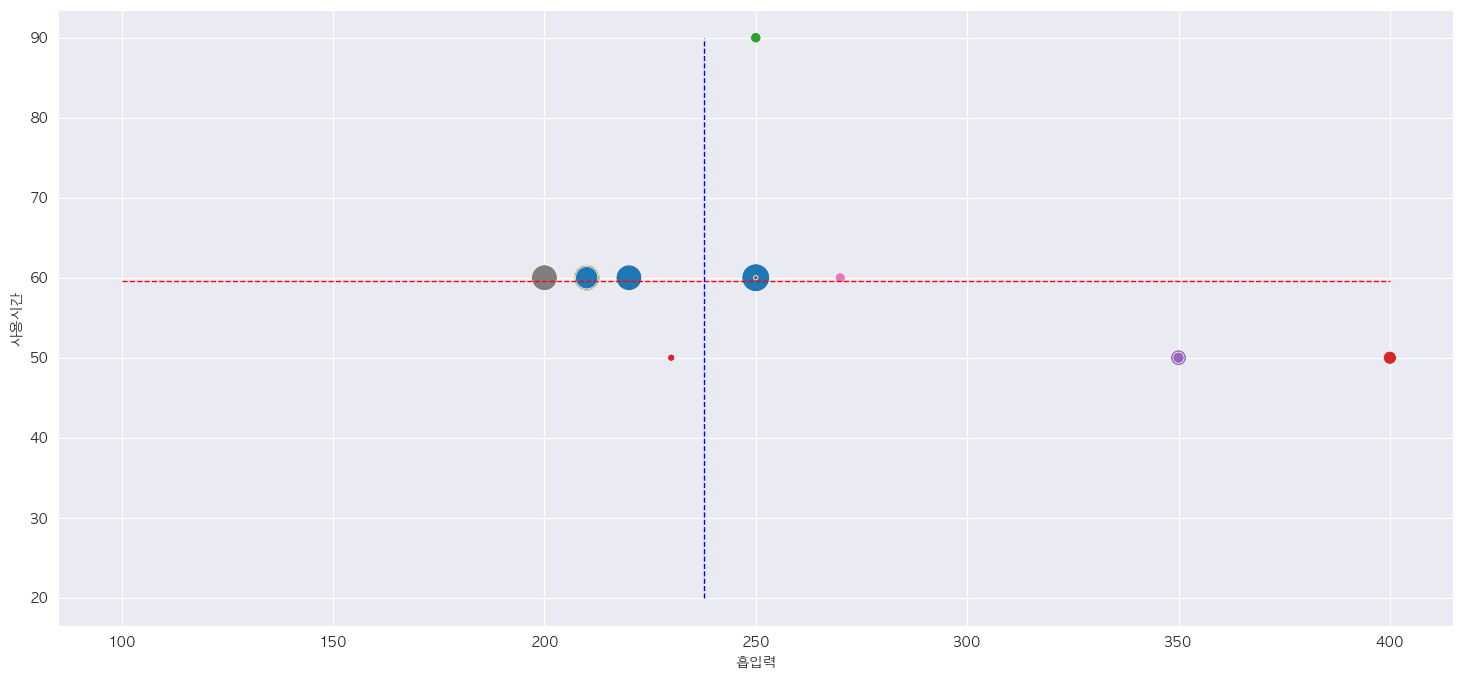

In [514]:
fig = plt.figure(figsize=(18, 8))

sns.scatterplot(data=chartData, x='흡입력', y='사용시간', size='가격', sizes=(10, 400), hue=chartData['제조회사'], legend=False)
plt.plot([100, suctionMax], [useTimeMean, useTimeMean], 'r--', lw=1) # 사용시간 평균치 줄표시
plt.plot([suctionMean, suctionMean], [20, useTimeMax], 'b--', lw=1) # 흡입력 평균치 줄표시

plt.show()

In [504]:
# chartData에서 상위 20개의 행을 선택하여 새로운 데이터프레임을 생성
chartDataTop = chartData[:20]

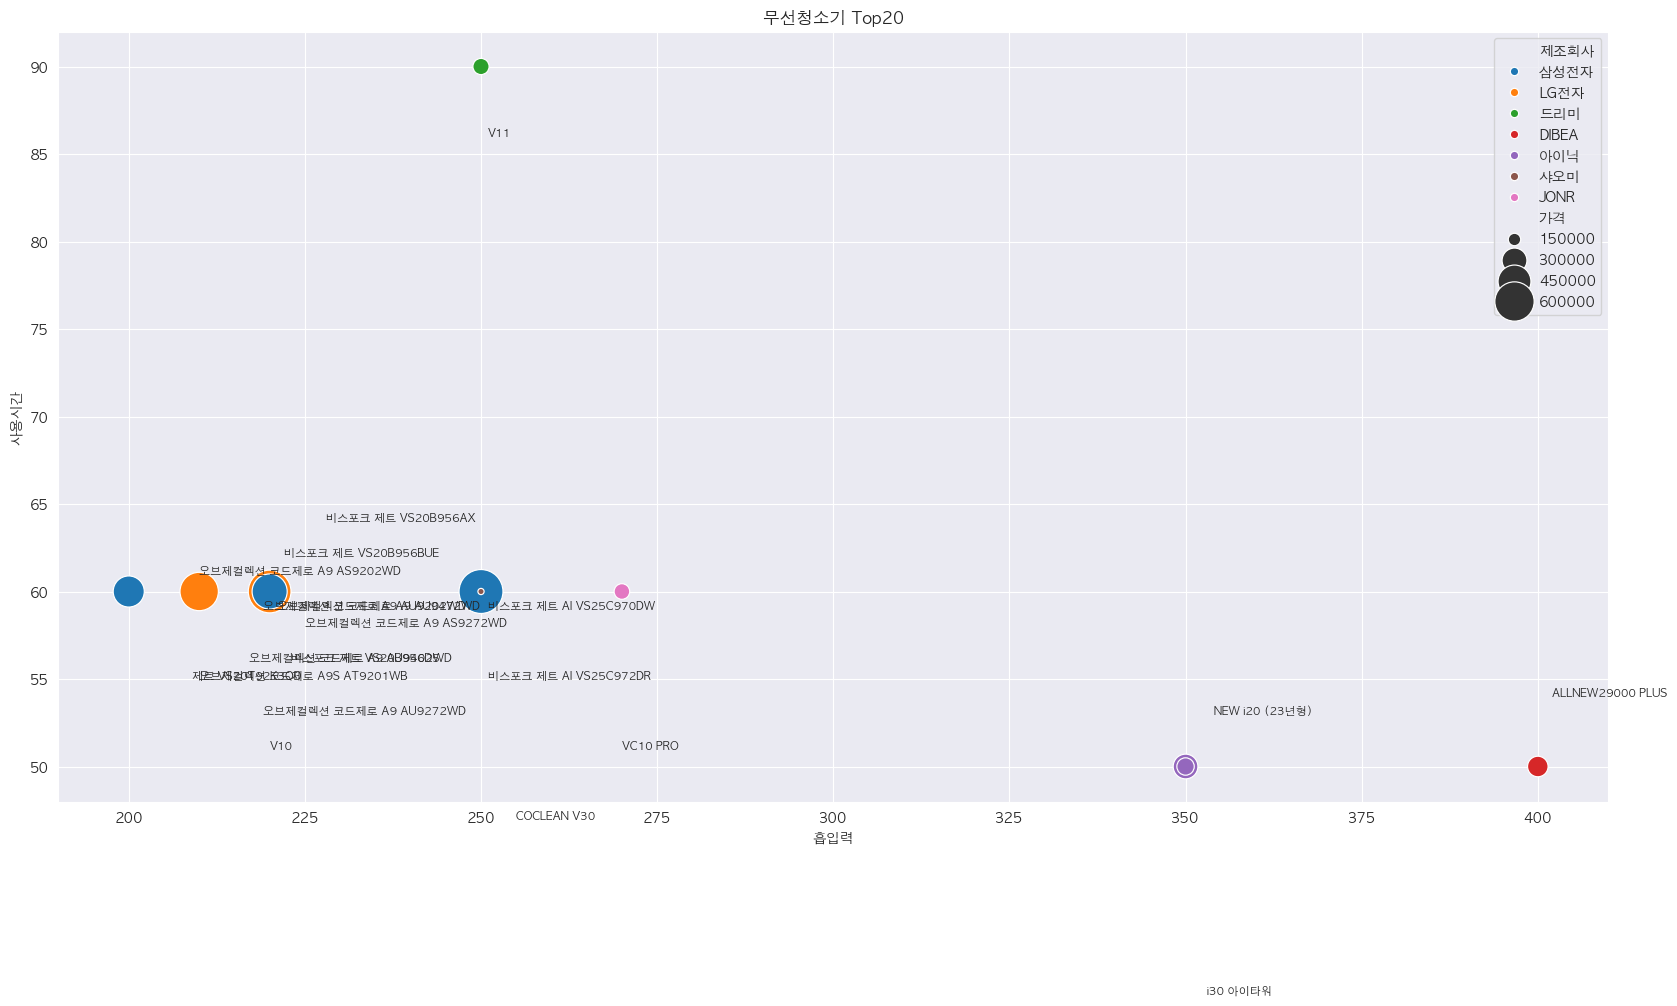

In [505]:
import random

# 인기제품 시각화
fig = plt.figure(figsize=(20, 10))
plt.title('무선청소기 Top20')
sns.scatterplot(data=chartDataTop, x='흡입력', y='사용시간', size='가격', sizes=(20, 1000),
                hue=chartDataTop['제조회사'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-3, 10)
    y = row['사용시간'] + random.randrange(-13, 5)
    s = row['제품명']
    plt.text(x, y, s, size=8)

plt.show()

##### 결론
1. 데이터분석을 위한 전처리는 쉽지 않음
2. 결과들이 예상이나, 실제와 많이 다름